# Comparing PCA and factor analysis

In [7]:
# Import libraries
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import FactorAnalysis
from matplotlib import animation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

Generate PVT data for an ideal gas

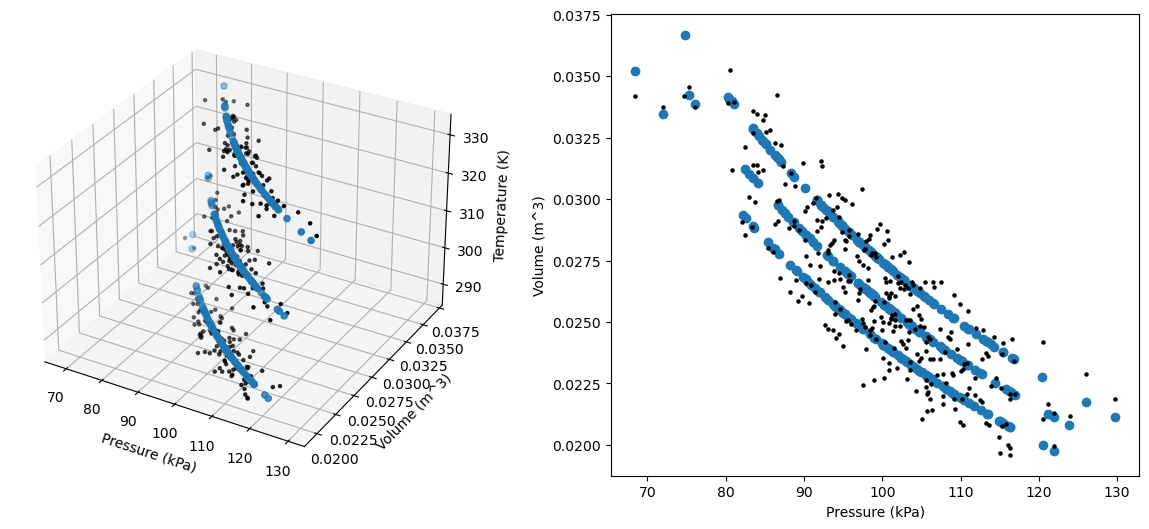

In [8]:
n = 100
N = 3*n     # Number of samples
R = 8.314   # Ideal gas constant
P = 1e5 + np.random.normal(0, 1e4, N)     # Pressure in Pa

# Temperature in K
T = np.ones_like(P)
T[:n] = 290    
T[n:2*n] = 310
T[2*n:] = 330 

V = R*T/P   # Volume in m^3
P = P/1000  # Pressure in kPa

measured_T = T + np.random.normal(0, 1, N)
measured_P = P + np.random.normal(0, 0.05, N)
measured_V = V + np.random.normal(0, 0.001, N)

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter3D(P, V, T)
ax.scatter3D(measured_P, measured_V, measured_T, c = 'k', s = 5)
ax.set_xlabel('Pressure (kPa)')
ax.set_ylabel('Volume (m^3)')
ax.set_zlabel('Temperature (K)')

ax = fig.add_subplot(122)
ax.scatter(P, V)
ax.scatter(measured_P, measured_V, c = 'k', s = 5)
ax.set_xlabel('Pressure (kPa)')
ax.set_ylabel('Volume (m^3)')

plt.show()

(-3.0, 3.0)

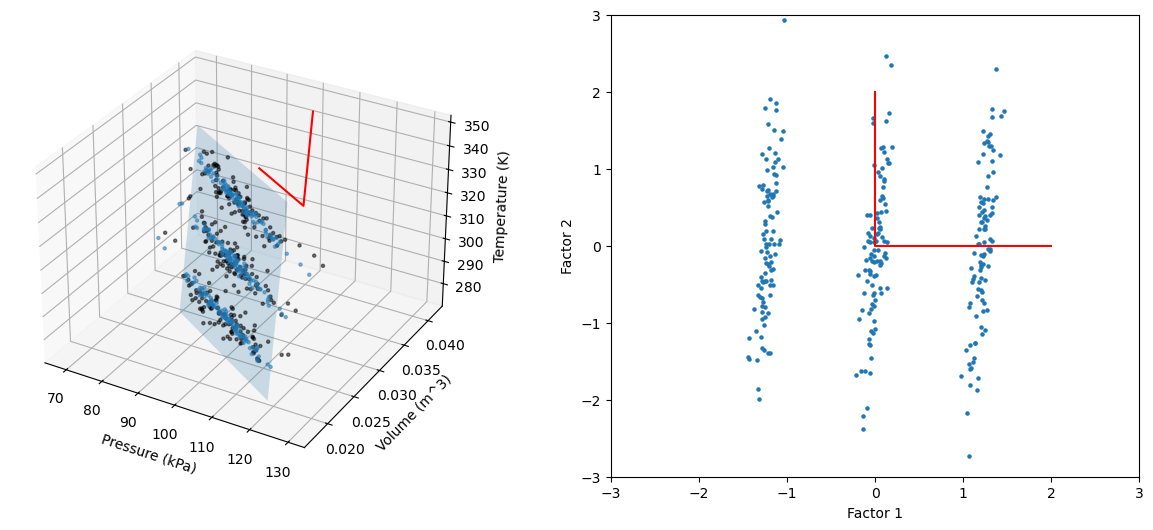

In [24]:
# Form the mean-centred data matrix Xc
X = np.concatenate((measured_P.reshape(-1,1), measured_V.reshape(-1,1), measured_T.reshape(-1,1)), axis = 1)
μ = np.mean(X, axis = 0)
Xc = X - μ 

FA = FactorAnalysis(n_components = 2)
FA.fit(Xc)
L = FA.components_.T
Ψ = np.diag(FA.noise_variance_)
C = np.linalg.inv(L @ L.T + Ψ)
F = ( L.T @ C @ Xc.T ).T # Equivalent to H = FA.transform(X)

# Create some code to enable the plotting of the surface
f1, f2 = np.meshgrid(np.linspace(-2, 2, 4), np.linspace(-2, 2, 4))
F_grid = np.concatenate((f1.reshape(-1,1), f2.reshape(-1,1)), axis = 1)
X_grid = F_grid @ L.T + μ 
F_coord = np.array([[2,0],[0,0],[0,2]])

# Add code to illustrate the rotation
θ = 0/2*np.pi
Q = np.array([[np.cos(θ), -np.sin(θ)], [np.sin(θ), np.cos(θ)]])
F = F @ Q
L = L @ Q
FL = F@L.T + μ 
X_coord = F_coord @ L.T + μ 

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X_grid[:,0].reshape(4,4), X_grid[:,1].reshape(4,4), X_grid[:,2].reshape(4,4), alpha = 0.2)
ax.scatter3D(X[:,0], X[:,1], X[:,2], c = 'k', s = 5, alpha = 0.5)
ax.scatter3D(FL[:,0], FL[:,1], FL[:,2], s = 5, alpha = 0.5)
ax.plot(X_coord[:,0]+5, X_coord[:,1]+0.01, X_coord[:,2]+5, c = 'r')
ax.set_xlabel('Pressure (kPa)')
ax.set_ylabel('Volume (m^3)')
ax.set_zlabel('Temperature (K)')

ax = fig.add_subplot(122)
ax.scatter(F[:,0], F[:,1], s = 5)
ax.plot(F_coord[:,0], F_coord[:,1], c = 'r')
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)


Progress: 0.00%
Progress: 0.00%
Progress: 1.67%
Progress: 3.33%
Progress: 5.00%
Progress: 6.67%
Progress: 8.33%
Progress: 10.00%
Progress: 11.67%
Progress: 13.33%
Progress: 15.00%
Progress: 16.67%
Progress: 18.33%
Progress: 20.00%
Progress: 21.67%
Progress: 23.33%
Progress: 25.00%
Progress: 26.67%
Progress: 28.33%
Progress: 30.00%
Progress: 31.67%
Progress: 33.33%
Progress: 35.00%
Progress: 36.67%
Progress: 38.33%
Progress: 40.00%
Progress: 41.67%
Progress: 43.33%
Progress: 45.00%
Progress: 46.67%
Progress: 48.33%
Progress: 50.00%
Progress: 51.67%
Progress: 53.33%
Progress: 55.00%
Progress: 56.67%
Progress: 58.33%
Progress: 60.00%
Progress: 61.67%
Progress: 63.33%
Progress: 65.00%
Progress: 66.67%
Progress: 68.33%
Progress: 70.00%
Progress: 71.67%
Progress: 73.33%
Progress: 75.00%
Progress: 76.67%
Progress: 78.33%
Progress: 80.00%
Progress: 81.67%
Progress: 83.33%
Progress: 85.00%
Progress: 86.67%
Progress: 88.33%
Progress: 90.00%
Progress: 91.67%
Progress: 93.33%
Progress: 95.00%
Prog

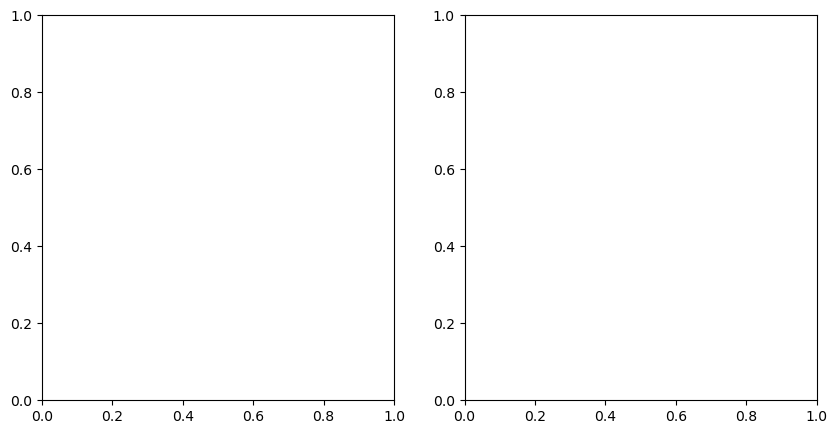

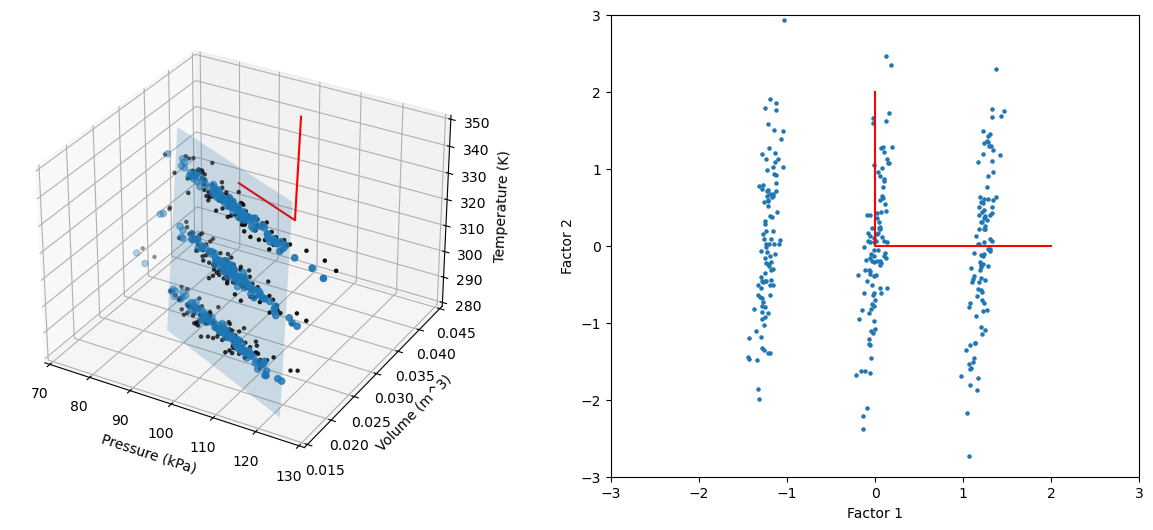

In [22]:
fig,ax = plt.subplots(1,2, figsize = (10,5))
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)
    
def AnimationFunction(t):

    L = FA.components_.T
    Ψ = np.diag(FA.noise_variance_)
    C = np.linalg.inv(L @ L.T + Ψ)
    F = ( L.T @ C @ Xc.T ).T # Equivalent to H = FA.transform(X)

    # Create rotation matrix
    θ = 2*t/60*np.pi
    Q = np.array([[np.cos(θ), -np.sin(θ)], [np.sin(θ), np.cos(θ)]])
    F = F @ Q
    L = L @ Q
    FL = F@L.T + μ 
    X_coord = F_coord @ L.T + μ 

    ax1.clear()
    ax1.plot_surface(X_grid[:,0].reshape(4,4), X_grid[:,1].reshape(4,4), X_grid[:,2].reshape(4,4), alpha = 0.2)
    ax1.scatter3D(X[:,0], X[:,1], X[:,2], c = 'k', s = 5)
    ax1.scatter3D(FL[:,0], FL[:,1], FL[:,2])
    ax1.plot(X_coord[:,0]+5, X_coord[:,1]+0.01, X_coord[:,2]+5, c = 'r')
    ax1.set_xlabel('Pressure (kPa)')
    ax1.set_ylabel('Volume (m^3)')
    ax1.set_zlabel('Temperature (K)')
    ax1.set_xlim([70, 130])
    ax1.set_ylim([0.015, 0.045])
    ax1.set_zlim([280, 350])
    
    ax2.clear()
    ax2.scatter(F[:,0], F[:,1], s = 5)
    ax2.plot(F_coord[:,0], F_coord[:,1], c = 'r')
    ax2.set_xlabel('Factor 1')
    ax2.set_ylabel('Factor 2')
    ax2.set_xlim(-3,3)
    ax2.set_ylim(-3,3)

    print(f"Progress: {t/60*100:.2f}%")

# Create the animation and save to file
anim = animation.FuncAnimation(fig, AnimationFunction, frames = 60, repeat=False)

# Create animation without PCA projection
# f = r"..\images\data-rotation.gif" 

# Create animation with PCA projection
f = r"..\images\FactorAnalysis-rotation.gif" 

writergif = animation.PillowWriter(fps=20) 
anim.save(f, writer=writergif)

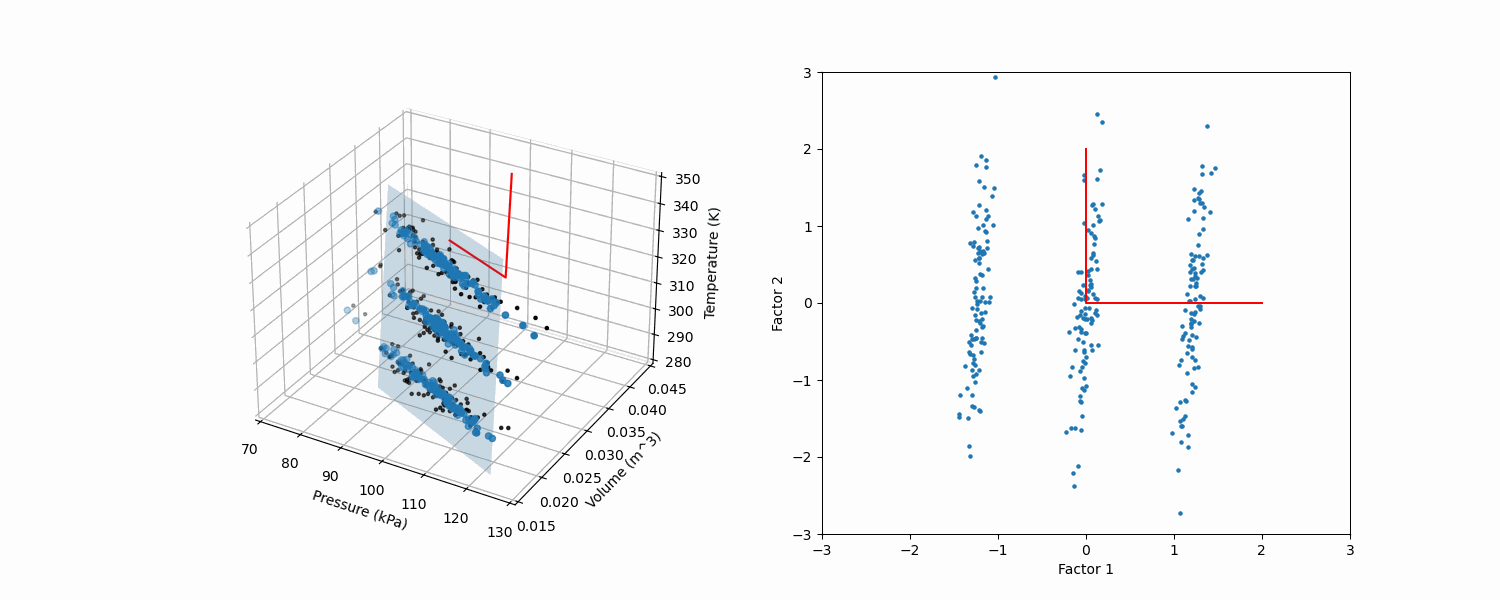

In [25]:
# Display the created gif
display(Image('..\images\FactorAnalysis-rotation.gif'))